데이터 벡터 형태: (200, 300)


Epoch 1/50

10/10 [==============================] - 5s 97ms/step - loss: 0.3128 - val_loss: 0.1729
Epoch 2/50
10/10 [==============================] - 0s 21ms/step - loss: 0.1028 - val_loss: 0.0435
Epoch 3/50
10/10 [==============================] - 0s 20ms/step - loss: 0.0315 - val_loss: 0.0251
Epoch 4/50
10/10 [==============================] - 0s 22ms/step - loss: 0.0232 - val_loss: 0.0216
Epoch 5/50
10/10 [==============================] - 0s 22ms/step - loss: 0.0205 - val_loss: 0.0199
Epoch 6/50
10/10 [==============================] - 0s 21ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 7/50
10/10 [==============================] - 0s 22ms/step - loss: 0.0184 - val_loss: 0.0179
Epoch 8/50
10/10 [==============================] - 0s 24ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 9/50
10/10 [==============================] - 0s 22ms/step - loss: 0.0159 - val_loss: 0.0155
Epoch 10/50
10/10 [==============================] - 0s 21ms/step - loss: 0.0145 - v

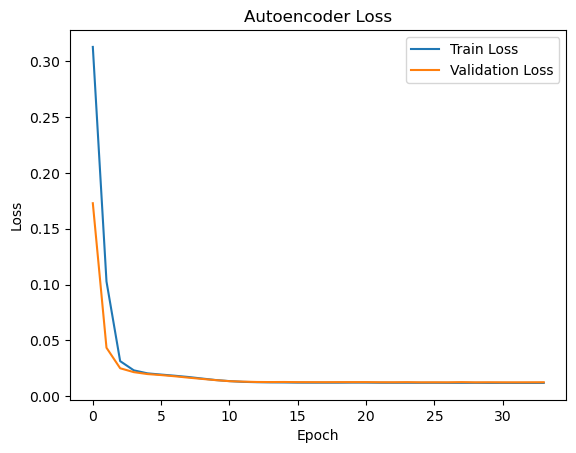

7/7 [==============================] - 0s 5ms/step
잠재 공간 특징 저장 완료: latent_features.csv


In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 데이터 경로 설정
data_dir = "hand_data"
files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

gesture_vectors = []
labels = []
fixed_length = 100  # 고정된 길이

def sample_frames(data, fixed_length):
    if len(data) < fixed_length:
        repeat_factor = int(np.ceil(fixed_length / len(data)))
        data = np.tile(data, (repeat_factor, 1))[:fixed_length]
    else:
        indices = np.linspace(0, len(data) - 1, fixed_length).astype(int)
        data = data[indices]
    return data

# 데이터를 먼저 모두 수집하여 스케일러를 fit하기 위한 리스트
all_data_list = []

for file in files:
    # 인코딩 지정하여 CSV 파일 읽기
    df = pd.read_csv(os.path.join(data_dir, file), encoding='cp949')  # 또는 'euc-kr', 'utf-8-sig' 등

    # 데이터에서 X, Y, Z 좌표만 추출
    data = df[['X', 'Y', 'Z']].values  # X, Y, Z 좌표 데이터만

    # 전체 데이터를 수집하여 스케일러를 fit하기 위해 저장
    all_data_list.append(data)

# 전체 데이터를 하나의 배열로 결합하여 스케일러를 fit
all_data = np.vstack(all_data_list)
scaler = MinMaxScaler()
scaler.fit(all_data)

# 각 파일별로 데이터 처리
for data, df_file in zip(all_data_list, files):
    # 데이터 정규화
    data = scaler.transform(data)

    # 데이터 압축: 샘플링
    normalized_data = sample_frames(data, fixed_length)
    gesture_vectors.append(normalized_data.flatten())

    # 레이블 추출 ('Gesture' 컬럼에서)
    df = pd.read_csv(os.path.join(data_dir, df_file), encoding='cp949')  # 동일한 인코딩으로 읽기
    label = df['Gesture'].iloc[0]
    labels.append(label)

# NumPy 배열로 변환
gesture_vectors = np.array(gesture_vectors)
print(f"데이터 벡터 형태: {gesture_vectors.shape}")  # (샘플 수, 고정 길이 × 3)

# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# 데이터 분리 (학습: 80%, 테스트: 20%)
X_train, X_test, y_train, y_test = train_test_split(
    gesture_vectors, numeric_labels, test_size=0.2, random_state=42
)

# 오토인코더 정의
input_dim = gesture_vectors.shape[1]  # 입력 차원
latent_dim = 16  # 잠재 공간 크기 (압축할 차원)

# 인코더 정의
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded_output = Dense(latent_dim)(encoded)  # 활성화 함수 없음

# 디코더 정의
decoded = Dense(64, activation='relu')(encoded_output)
decoded = Dense(128, activation='relu')(decoded)
decoded_output = Dense(input_dim)(decoded)  # 활성화 함수 없음

# 오토인코더 모델
autoencoder = Model(inputs=input_layer, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

# 인코더 모델
encoder = Model(inputs=input_layer, outputs=encoded_output)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=16,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[early_stopping]
)

# 학습 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Loss')
plt.show()

# 잠재 공간 데이터 생성
latent_features = encoder.predict(gesture_vectors)

# 잠재 특징 저장
latent_df = pd.DataFrame(latent_features, columns=[f"Latent_{i}" for i in range(latent_features.shape[1])])
latent_df['Label'] = numeric_labels  # 인코딩된 숫자 레이블 추가
latent_df.to_csv("latent_features.csv", index=False)

print("잠재 공간 특징 저장 완료: latent_features.csv")

# 레이블 매핑 저장 (숫자 레이블과 문자열 레이블의 대응 관계)
import pickle

with open('label_mapping.pkl', 'wb') as f:
    pickle.dump(label_encoder.classes_, f)


In [5]:
# 데이터 분리 (이미 분리된 데이터를 사용)
X_train_latent, X_test_latent, y_train, y_test = train_test_split(
    latent_features, numeric_labels, test_size=0.2, random_state=42
)

# 분류기 정의
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

classifier = Sequential([
    Dense(32, activation='relu', input_shape=(latent_dim,)),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 학습
classifier.fit(
    X_train_latent, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_latent, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# 평가
loss, accuracy = classifier.evaluate(X_test_latent, y_test)
print(f"테스트 정확도: {accuracy * 100:.2f}%")


Epoch 1/50

10/10 [==============================] - 3s 71ms/step - loss: 0.7067 - accuracy: 0.5562 - val_loss: 0.6419 - val_accuracy: 0.5250
Epoch 2/50
10/10 [==============================] - 0s 21ms/step - loss: 0.6397 - accuracy: 0.4938 - val_loss: 0.5953 - val_accuracy: 0.5250
Epoch 3/50
10/10 [==============================] - 0s 22ms/step - loss: 0.5847 - accuracy: 0.7063 - val_loss: 0.5474 - val_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 0s 21ms/step - loss: 0.5313 - accuracy: 1.0000 - val_loss: 0.4979 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 0s 21ms/step - loss: 0.4781 - accuracy: 0.9937 - val_loss: 0.4427 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 0s 21ms/step - loss: 0.4240 - accuracy: 1.0000 - val_loss: 0.3880 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 0s 21ms/step - loss: 0.3678 - accuracy: 1.0000 - val_loss: 0.3290 - val_accuracy: 1.0000
Epoch 8/50
1

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 테스트 데이터에 대한 재구성
X_test_reconstructed = autoencoder.predict(X_test)

# 각 샘플에 대한 재구성 오류 계산
reconstruction_errors = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# 전체 재구성 오류의 평균
mean_reconstruction_error = np.mean(reconstruction_errors)
print(f"테스트 데이터에 대한 평균 재구성 오류: {mean_reconstruction_error}")


2/2 [==============================] - 0s 9ms/step
테스트 데이터에 대한 평균 재구성 오류: 0.01247197028375498


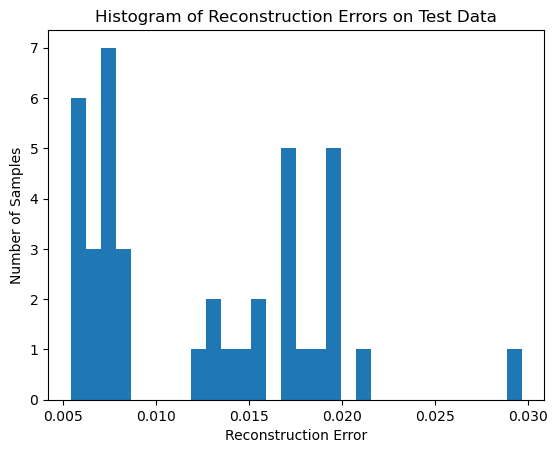

In [7]:
import matplotlib.pyplot as plt

plt.hist(reconstruction_errors, bins=30)
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.title('Histogram of Reconstruction Errors on Test Data')
plt.show()


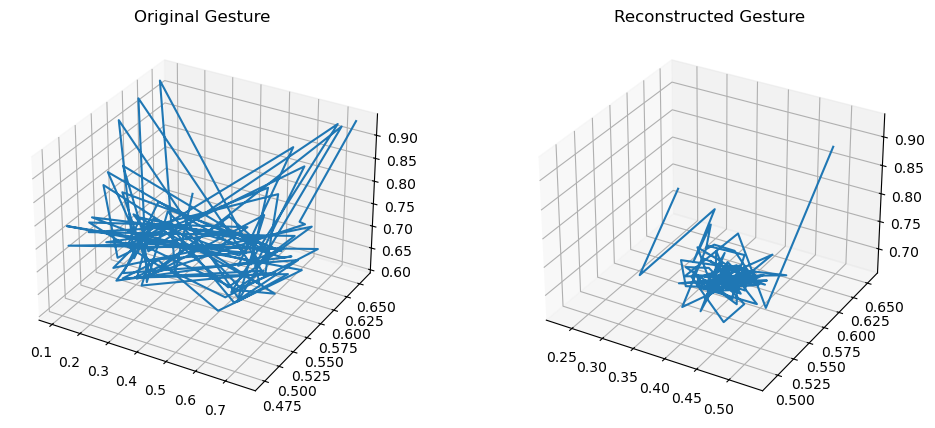

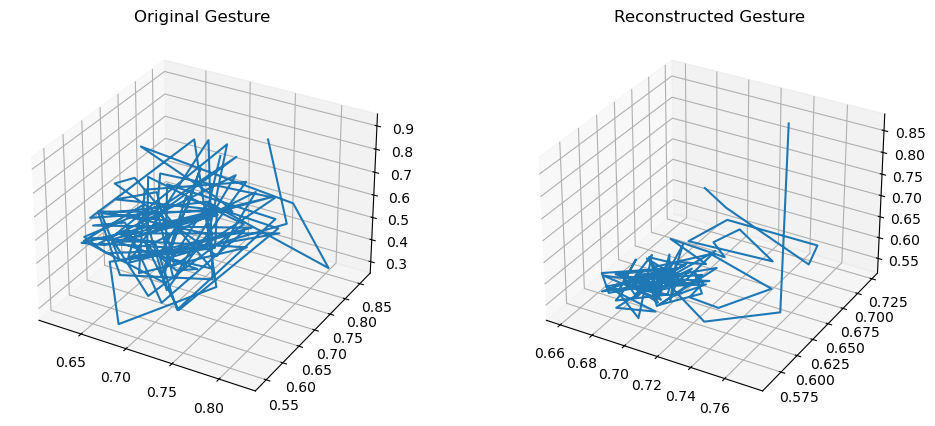

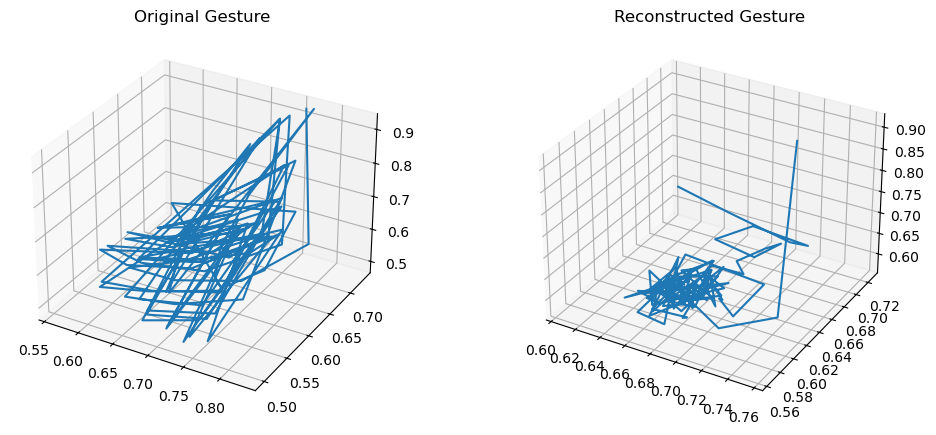

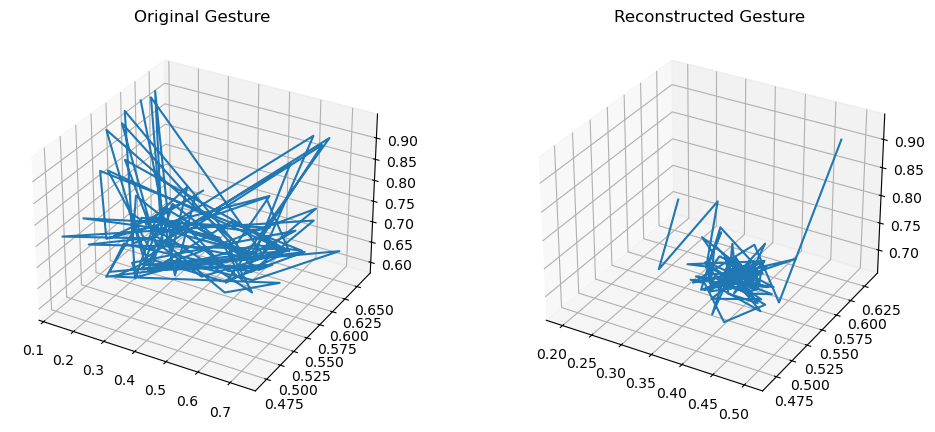

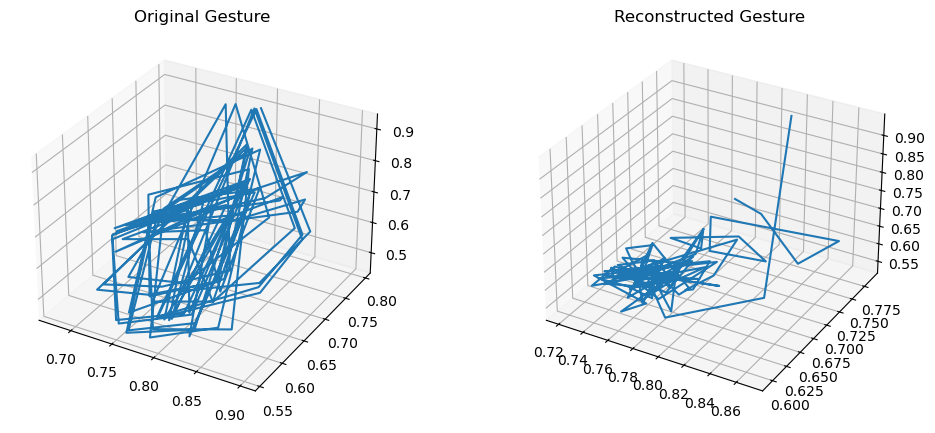

In [8]:
# 샘플 선택
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in indices:
    original = X_test[idx].reshape(fixed_length, 3)
    reconstructed = X_test_reconstructed[idx].reshape(fixed_length, 3)

    # 원본 데이터 시각화
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot(original[:, 0], original[:, 1], original[:, 2])
    ax1.set_title('Original Gesture')

    # 재구성된 데이터 시각화
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2])
    ax2.set_title('Reconstructed Gesture')

    plt.show()


In [9]:
# 훈련 및 검증 손실 출력
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"최종 훈련 손실: {final_train_loss}")
print(f"최종 검증 손실: {final_val_loss}")


최종 훈련 손실: 0.011965393088757992
최종 검증 손실: 0.012548972852528095


In [ ]:
# 라벨링 필요없다면..

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 데이터 경로 설정
data_dir = "hand_data"
files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

gesture_vectors = []
labels = []
fixed_length = 100  # 고정된 길이

def sample_frames(data, fixed_length):
    if len(data) < fixed_length:
        repeat_factor = int(np.ceil(fixed_length / len(data)))
        data = np.tile(data, (repeat_factor, 1))[:fixed_length]
    else:
        indices = np.linspace(0, len(data) - 1, fixed_length).astype(int)
        data = data[indices]
    return data

scaler = MinMaxScaler()

for file in files:
    df = pd.read_csv(os.path.join(data_dir, file))
    data = df[['X', 'Y', 'Z']].values  # X, Y, Z 좌표 데이터만

    # 데이터 정규화
    data = scaler.fit_transform(data)

    # 데이터 압축: 샘플링
    normalized_data = sample_frames(data, fixed_length)
    gesture_vectors.append(normalized_data.flatten())

    # 레이블 추출
    try:
        label = file.split('_')[0]
        labels.append(label)
    except IndexError:
        labels.append('Unknown')

# NumPy 배열로 변환
gesture_vectors = np.array(gesture_vectors)
print(f"데이터 벡터 형태: {gesture_vectors.shape}")  # (샘플 수, 고정 길이 × 3)

# 데이터 분리 (학습: 80%, 테스트: 20%)
X_train, X_test = train_test_split(gesture_vectors, test_size=0.2, random_state=42)

# 오토인코더 정의
input_dim = gesture_vectors.shape[1]  # 입력 차원
latent_dim = 16  # 잠재 공간 크기 (압축할 차원)

# 인코더 정의
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded_output = Dense(latent_dim)(encoded)  # 활성화 함수 없음

# 디코더 정의
decoded = Dense(64, activation='relu')(encoded_output)
decoded = Dense(128, activation='relu')(decoded)
decoded_output = Dense(input_dim)(decoded)  # 활성화 함수 없음

# 오토인코더 모델
autoencoder = Model(inputs=input_layer, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss='mse')

# 인코더 모델
encoder = Model(inputs=input_layer, outputs=encoded_output)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = autoencoder.fit(
    X_train, X_train,  # 입력과 출력이 동일
    epochs=50,
    batch_size=16,
    validation_data=(X_test, X_test),
    shuffle=True,
    callbacks=[early_stopping]
)

# 학습 결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Loss')
plt.show()

# 잠재 공간 데이터 생성
latent_features = encoder.predict(gesture_vectors)

# 잠재 특징 저장
latent_df = pd.DataFrame(latent_features, columns=[f"Latent_{i}" for i in range(latent_features.shape[1])])
latent_df['Label'] = labels  # 레이블 추가
latent_df.to_csv("latent_features.csv", index=False)

print("잠재 공간 특징 저장 완료: latent_features.csv")